In [3]:
# This is for testing the Device using for this project
# import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2023-12-07 12:25:07.395673: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 12:25:07.395754: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 12:25:07.395793: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 12:25:07.409914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-07 12:25:10.927566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 12:25:10.966379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 12:25:10.966424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## 1. Import trained models

In [1]:
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model_car = YOLO('models/car.pt')
model_plate = YOLO('models/plate1.pt')

# Define path to the image file
# source = 'data/images/test4.jpg'

## 2. Define function for detecting and segment the vehicles and plates

In [2]:
import numpy as np
import shutil
import os

# Clear and create debug folder
# WARNING: Do not store anything in folder debug
def findPlate(path):
    if os.path.exists('./debug'):
        shutil.rmtree('./debug')
    if not os.path.exists('./debug'):
        os.makedirs('./debug')

    cars = model_car(path)

    for car in cars:
        car.save_crop(save_dir='./debug')

    try:
        car_dir = os.listdir('./debug/Car/')
        for d in car_dir:
            plates_car = model_plate('debug/Car/'+d)
            plates_car[0].save_crop(save_dir=('./debug'))
            # for plate in plates_car:
            #     plate.save_crop(save_dir=('./debug'))
            # plates_car[0].save_crop(save_dir=('./debug'))
        
    except:
        print("No car detected")

    try:
        plates_motor = model_plate('debug/Motorcycle')
        for plate in plates_motor:
            plate.save_crop(save_dir=('./debug'))
        # plates_motor[0].save_crop(save_dir=('./debug'))
    except:
        print("No motorbike detected")

## 3. Use image processing methods to extract the characters
### 3.1. Increase the contrast and eleminate noises

In [3]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

def postProcess(path):
    img=cv2.imread('./debug/Plate/im.jpg',0)
    img=255-img
    # Resize the image
    if(img.shape[1]*1.0/img.shape[0]>2.3):
        img = cv2.resize(img,(400,200),interpolation=0)
    else:
        img = cv2.resize(img,(400,400),interpolation=0)
    # img = cv2.resize(img,(200,200),img,interpolation=0)

    newimg = np.zeros((img.shape),dtype='uint8')
    # Define the parameters
    t1=50
    t2=100
    t3=250
    # f(x) = log(x - t1) * t2 - t3
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i,j]<=t1): newimg[i,j]=0
            else: newimg[i,j] =np.clip(math.log(img[i,j]-t1)*t2-t3,0,255)
    cv2.threshold(newimg,150,255,cv2.THRESH_BINARY,newimg)
    kernel_size = 1
    denoise_img = np.zeros(newimg.shape,dtype='uint8')
    for i in range(kernel_size,newimg.shape[0]-kernel_size):
        for j in range(kernel_size,newimg.shape[1]-kernel_size):
            denoise_img[i,j]=np.median(newimg[i-kernel_size:i+kernel_size,j-kernel_size:j+kernel_size])

    newimg = denoise_img.copy()
    d = 60
    # Denoise the image
    cv2.erode(newimg,np.ones((3,3)),newimg)
    cv2.threshold(newimg,127,255,cv2.THRESH_BINARY,newimg)
    newimg=cv2.morphologyEx(newimg,cv2.MORPH_TOPHAT,np.ones((20,25)))
    cv2.threshold(newimg,127,255,cv2.THRESH_BINARY,newimg)
    # cv2.erode(denoise_img,np.ones((5,5)),denoise_img)
    cv2.imwrite('save.jpg',newimg)
    plt.imshow(newimg,cmap='gray')
    plt.show()

### 3.2. Define function for arranging contours

In [4]:
def get_contour_precedence(contour, cols):
    tolerance_factor = 80
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

### 3.3. Get contours and extract each character

In [5]:
def extractChars(path):
    img = cv2.imread('./save.jpg',0)
    # if(img.shape[1]*1.0/img.shape[0]>2.3):
    #     img = cv2.resize(img,(400,200),interpolation=0)
    # else:
    #     img = cv2.resize(img,(400,400),interpolation=0)
    cv2.threshold(img,180,255,cv2.THRESH_BINARY,img)
    print(img.shape)
    # img = 255-img
    img3channels = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
    cv2.floodFill

    char_contours=[]
    chars=[]
    for contour in contours:
        x,y,w,h=cv2.boundingRect(contour)
        if(w>15 and w<100 and h > 70 and h < 130):
            char_contours.append(contour)
            cv2.rectangle(img3channels,(x,y),(x+w,y+h),(0,127,0),2)
            # cv2.drawContours(img3channels, [contour], 0, (0,255,0), 2)
    char_contours.sort(key=lambda x:get_contour_precedence(x, img.shape[1]))
    for cnt in char_contours:
        x,y,w,h=cv2.boundingRect(cnt)
        chars.append(img[y:y+h,x:x+w])

    try:
        shutil.rmtree('./debug/chars/')
    except:
        pass
    os.makedirs('./debug/chars')
    i = 0
    for char in chars:
        temp = char.copy()
        # temp = cv2.resize(temp,(28,28),interpolation=0)
        # temp = cv2.blur(temp,(3,3))
        cv2.imwrite('./debug/chars/img'+str(i)+'.jpg',temp)
        i+=1
    plt.imshow(img3channels)
    # mask =np.zeros((202,402),np.uint8)
    # cv2.floodFill(img,mask,(50,50),255)
    # plt.imshow(mask,cmap='gray')
    mask1 = np.zeros(img.shape[:-1],np.uint8)

    plt.show()

## 4. Use Tesseract OCR to read the characters

In [10]:
def readChars():
    chars_dir = os.listdir('./debug/chars/')
    i=0
    if not os.path.exists('./debug/read'):
        os.makedirs('./debug/read')
    for c in range(len(chars_dir)):
        p = './debug/read/img'+str(i)+'.jpg'
        if(i!=2):
            !tesseract -c tessedit_char_whitelist=0123456789 ./debug/chars/img{c}.jpg ./debug/read/result{i} -l plate --psm 10 --oem 0
        else:
            !tesseract -c tessedit_char_whitelist=ABCDEFGHKLMNPSTVXZY ./debug/chars/img{c}.jpg ./debug/read/result{i} -l plate --psm 10 --oem 0
        # else:
        #     !tesseract -c tessedit_char_whitelist= ./debug/chars/img{c}.jpg ./debug/read/result{i} -l plate --psm 10 --oem 0
        i+=1

In [11]:
# from keras.models import load_model
# from keras import models

# model = models.load_model('./models/mnist.h5')

In [12]:
# chars_dir = os.listdir('./debug/chars/')
# normalized_chars = np.zeros((len(chars_dir),28,28))
# for c in range(len(chars_dir)):
#     temp = cv2.imread('./debug/chars/img'+str(c)+'.jpg',0)
#     temp = np.array(temp,np.float32)/255
#     for i in range(temp.shape[0]):
#         for j in range(temp.shape[1]):
#             normalized_chars[c]=temp
# normalized_chars = normalized_chars.reshape((len(chars_dir),28,28,1))
#     # normalized_chars.append(np.array(temp,np.float32)/255)
# nums = model.predict([normalized_chars])
# for c in range(len(chars_dir)): 
#     print(np.argmax(nums[c]))

## 5. GUI


image 1/1 /home/phi/AI/YOLO/YOLOv8/data/images/IMG20231211170738.jpg: 640x480 2 Cars, 139.4ms
Speed: 307.1ms preprocess, 139.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/phi/AI/YOLO/YOLOv8/debug/Car/im.jpg: 544x640 (no detections), 25.2ms
Speed: 4.3ms preprocess, 25.2ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /home/phi/AI/YOLO/YOLOv8/debug/Car/im2.jpg: 544x640 1 Plate, 25.4ms
Speed: 4.9ms preprocess, 25.4ms inference, 7.1ms postprocess per image at shape (1, 3, 544, 640)

No motorbike detected


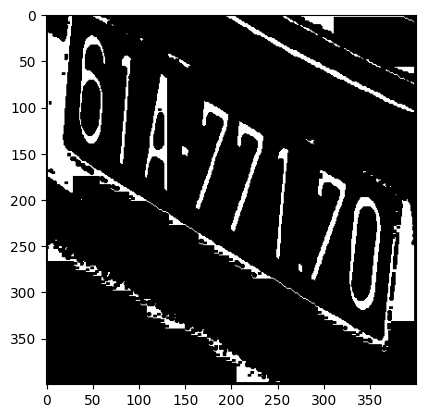

(400, 400)


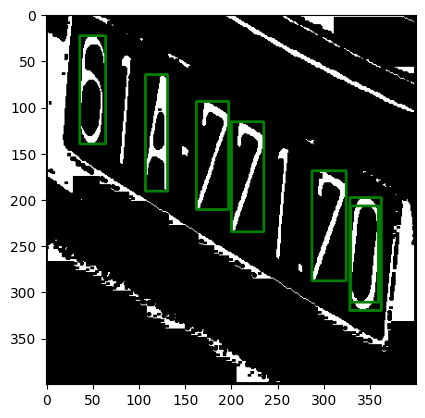

Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
Tesseract Open Source OCR Engine v4.1.1 with Leptonica
587700


In [13]:
from cProfile import label
from tkinter.filedialog import askopenfilename
from tkinter import *
from PIL import ImageTk, Image
from IPython.display import clear_output


root = Tk()
root.title('ANPR')
inform = StringVar(root)
inform.set("Please open the image")

def OpenImage():
    try:
        clear_output(wait=False)

        path = askopenfilename()
        origin = Image.open(path)
        img = origin.resize((400,300))
        img = ImageTk.PhotoImage(img)
        l1.configure(image=img)
        l1.image = img
        findPlate(path)
        postProcess(path)
        extractChars(path)
        readChars()
        # inform.set(main.ReadPlate(path=path))
        chars_dir = os.listdir('./debug/read/')
        p=''
        for c in range(len(chars_dir)):
            path = './debug/read/result' + str(c) + '.txt'
            with open(path) as f:
                # p += f.readlines()
                # print(f.readlines()[0])
                p+=(f.readlines()[0][0])
                f.close()
            pass
        print(p)

        inform.set(p)
        contour = Image.open('./debug/Plate/im.jpg')
        contour = contour.resize((400,150))
        contour=ImageTk.PhotoImage(contour)
        l2.configure(image=contour)
        l2.image = contour
    except Exception as err:
        print(err)
        l1.configure(image=MissImage)
        l2.configure(image=MissImage)
        l1.image = MissImage
        l2.image = MissImage
        inform.set('Cannot open the image')

missingPath = './data/missing.png'
origin = Image.open(missingPath)
MissImage = origin.resize((400,300))
MissImage = ImageTk.PhotoImage(MissImage)

l1 = Label(root,image=MissImage)
l1.config(width=400,height=300)
l1.grid(row=1,column=1)
# l1.pack()

l2 = Label(root,image=MissImage)
l2.config(width=400,height=300)
l2.grid(row=1,column=2)
# l2.pack()

l3 = Label(root,textvariable=inform)
# l3.config(width=400,height=50)
l3.grid(row=2,column=1)
button = Button(root,text="Choose image",command = OpenImage)
button.grid(row=2,column=2)
# button.pack()

# l3.pack()
root.mainloop()
# filename = filename.split()
# print(type(filename))